## Setup

In [72]:
# ---------------------------------------------------
# 📦 LIBRERÍAS
# ---------------------------------------------------
from google.cloud import bigquery
from io import BytesIO
from PIL import Image
from google.api_core import exceptions
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseUpload
from google import genai
from google.genai.types import Part, GenerateContentConfig
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google import auth
from pathlib import Path
from google.genai import types
# ---------------------------------------------------

# 📦 Parámetros de configuración

PROJECT = "lmes-aiforlmes-d-f86"
LOCATION = "europe-west1"
AI_MODEL_NAME = "gemini-2.5-flash-image"
# AI_MODEL_NAME = "gemini-3-pro-image-preview"
MODEL_SELECT_IMAGE = "gemini-2.5-flash"
FOLDER_IMAGES = "./imagenes_dameo_cotas/"
DRIVE_FOLDER_NAME = "Pruebas_cotas"

# reference = 98935772
# reference = 18356891
# reference = 83654838
# reference = 83654837
# reference = 95991524
# reference = 95991525
# reference = 84317134
# reference = 85606987
# reference = 92118687
# reference = 91521476
reference = 85206421

genai_client = genai.Client(vertexai=True, project=PROJECT, location="europe-west1")

client = bigquery.Client(project=PROJECT, location="EU")

# Usa las credenciales configuradas con gcloud auth application-default login
# Los scopes ya están incluidos en las credenciales ADC
creds, _ = auth.default()
drive_service = build('drive', 'v3', credentials=creds)

## Prompts, funciones auxiliares,  y queries

### Prompts

In [73]:
PICTOGRAM_PROMPT = """
{{
  "task_description": "Based on the provided reference image, create a single, highly detailed, black and white line art illustration of the product. The output must be a pure visual representation without any annotations, text, or dimensions.",
  "style_definition": {{"primary_style": "professional technical drawing", "secondary_style": "architectural blueprint", "rendering_quality": "hyperrealistic_detail", "color_palette": "black_and_white_monochrome", "line_work": "clean, crisp, precise, and well-defined lines", "shading": "none (strictly no fills, no gradients, no shadows)"}},
  "technical_specifications": {{"resolution": "high-definition, print_quality", "rendering": "maximum_anti-aliasing, no_noise_artifacts", "perspective": "maintain the exact perspective, angle, and proportions from the reference image"}},
  "content_rules": {{"subject": "Depict the product ONLY. Trace the reference image to capture its exact solid form, layered structure, and all visible material properties and textures (e.g., wood grain, metal finishes, small grooves, screws).", "background": "pure_white, completely empty, no environmental elements", "annotations": "strictly_forbidden (absolutely no dimensions, no labels, no text, no arrows, no measurements of any kind)"}},
  "output_specifications": {{"composition": "Ensure the entire product illustration is centered and fully visible within the canvas.", "margins": "Provide a small, consistent white margin (approximately 5-10%) around the product to prevent cropping."}}
}} """

# --- CRITICAL REQUIREMENTS ---

# **DIMENSION LINE STYLE:**

# **IMPORTANT: Each dimension line must consist of EXACTLY these components:**

# 1. **Dimension Line (ONE per dimension):**
#    - ONE single continuous line from the edges of the product dimension being measured
#    - Parallel to the dimension being measured
#    - Solid black color

# 2. **Arrowheads (TWO per dimension line):**
#     - ONE arrowhead at EACH end of the dimension line
#     - Aligned with dimension line direction

# 3. **Text Label (ONE per dimension):**
#     - Format: "[VALUE] [UNIT]" (e.g., "105 cm", "137,8 cm", "48 cm")
#     - Position: Centered on or slightly above the dimension line
#     - Font: Arial or Helvetica, sans-serif
#     - Size: Readable 
#     - Color: Solid black 

# **TEXT ORIENTATION:**
# - **Horizontal dimensions (width):** Text horizontal, readable from bottom
# - **Vertical dimensions (height):** Text rotated 90° counterclockwise, readable from left side
# - **Angled dimensions (depth):** Text parallel to dimension line, readable when viewed along the line

# **DECIMAL SEPARATOR:**
# - Use COMMA (,) as decimal separator (e.g., "137,8 cm" NOT "137.8 cm")

# --- MANDATORY CONSTRAINTS ---

# ✓ Add ONE dimension line per each dimension given in the input (width, height and/or depth)
# ✓ Each dimension line must have TWO arrowheads (one at each end)
# ✓ Always include the unit of measure (cm, mm, etc.)
# ✓ Use COMMA (,) as decimal separator
# ✓ Ensure dimension lines do NOT overlap with:
#   - Product illustration
#   - Other dimension lines
#   - Text labels
# ✓ Maintain professional, clean appearance with adequate spacing

# """

SELECT_BETTER_IMAGE_PROMPT = """

=== TASK: SELECT THE BEST IMAGE FOR ADDING TECHNICAL DIMENSION LINES ===

You are an expert image analyst specializing in technical drawings and product dimensioning. 
You are provided with multiple images of a product. Your task is to:
1. Select the SINGLE BEST image for adding technical dimension lines 
2. Determine if 3D dimensioning is possible or if only 2D dimensioning can be applied
3. Provide reasoning for your selection

--- SELECTION CRITERIA (Priority Order) ---

**PRIORITY 1 - 3D PERSPECTIVE PREFERRED IF THERE ARE THREE DIMENSION MEASUREMENTS IF NOT DO NOT TAKE INTO ACCOUNT THIS PRIORITY:**
✓ Images showing the product from an isometric, oblique, or three-quarter view angle
✓ Multiple visible faces/sides of the product (ideally showing width, height, AND depth simultaneously)
✓ Clear depth perception and spatial relationships between product components
✓ Visible corners or edges that reveal the product's three-dimensional form
✓ Perspective that allows placement of dimension lines in all three axes (X, Y, Z)

**PRIORITY 2 - CLEAR 2D VIEW (ACCEPTABLE IF 3D NOT AVAILABLE or NOT THREE DIMENSION MEASUREMENTS):**
✓ Front, side, or top orthogonal views with clear, unobstructed product outline
✓ Flat perspective showing two primary dimensions clearly (e.g., width × height OR width × depth)
✓ Minimal foreshortening or perspective distortion
✓ Clean background that won't interfere with dimension line placement

**GENERAL QUALITY REQUIREMENTS:**
✓ High resolution and sharp focus (no blur)
✓ Good lighting with clear visibility of product edges and contours
✓ Product fully visible within the frame (not cropped or cut off)
✓ Sufficient white space/margins around the product for dimension line annotations
✓ Clean, uncluttered background (preferably white or neutral)
✓ No overlapping objects, hands, or other distracting elements

**AVOID:**
✗ Extreme close-ups showing only partial product details
✗ Images with heavy shadows, glare, or poor lighting
✗ Perspective angles that hide critical dimensions
✗ Low-resolution or blurry images
✗ Images with busy backgrounds or overlapping products

--- OUTPUT FORMAT (JSON) ---

Respond ONLY with valid JSON in this exact format:

{
    "selected_index": <integer from 1 to N>,
    "dimensioning_type": "<3D or 2D>",
    "can_add_3d_dimensions": <true or false>,
    "confidence": "<high, medium, or low>",
    "reasoning": "<concise explanation of why this image was selected and why it supports 3D or only 2D dimensioning>",
    "visible_dimensions": {
        "width": <true or false>,
        "height": <true or false>,
        "depth": <true or false>
    },
    "quality_score": <integer from 1 to 10>,
    "alternative_suggestions": "<optional: if selected image is suboptimal, suggest which other image index might work better for specific use cases>"
}

--- DECISION LOGIC ---

**IF 3D perspective is available:**
- Set "dimensioning_type": "3D"
- Set "can_add_3d_dimensions": true
- All three dimensions (width, /length, depth) should be marked as visible
- Confidence should be "high" if perspective is clear

**IF only 2D views are available:**
- Set "dimensioning_type": "2D"
- Set "can_add_3d_dimensions": false
- Mark only the two visible dimensions as true
- Select the view that shows the MOST IMPORTANT dimensions (usually front view with width × height)

**EXAMPLE SCENARIOS:**

Example 1 - 3D Perspective Available:
{
    "selected_index": 2,
    "dimensioning_type": "3D",
    "can_add_3d_dimensions": true,
    "confidence": "high",
    "reasoning": "Image 2 shows an isometric view with clear visibility of all three dimensions. There are three dimension measurements. The product is photographed from a three-quarter angle, allowing simultaneous display of width, height, and depth. Good lighting and margins for dimension lines.",
    "visible_dimensions": {"width": true, "height": true, "depth": true},
    "quality_score": 9,
    "alternative_suggestions": ""
}

Example 2 - Only 2D View Available:
{
    "selected_index": 1,
    "dimensioning_type": "2D",
    "can_add_3d_dimensions": false,
    "confidence": "medium",
    "reasoning": "All images show flat orthogonal views. Image 1 (front view) is selected as it clearly displays width and height dimensions. Depth is not visible from this angle. Image quality is good but limited to 2D dimensioning.",
    "visible_dimensions": {"width": true, "height": true, "depth": false},
    "quality_score": 7,
    "alternative_suggestions": "If depth dimension is critical, consider obtaining an additional image with 3D perspective."
}

--- IMPORTANT NOTES ---
- If multiple 3D images exist, choose the one with the clearest view and best lighting
- Be conservative: only mark can_add_3d_dimensions as true if depth is genuinely visible and measurable
- The selected image must allow clear placement of dimension lines WITHOUT obscuring the product illustration
"""

### Queries

In [74]:
# sql_opus_dimensiones = f"""
# SELECT productReferenceBu, t.type, media_item.type, media_item.url, media_item.label
# FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_MEDIA_V1_com_adeo_CatalogsBroadcast_ProductCoreMediaValue` as t,
# UNNEST(media) AS media_item
# WHERE TIMESTAMP_TRUNC(_PARTITIONTIME, DAY) = TIMESTAMP("2025-09-19") and media_item.type = "photo"
# """
# opus_dimensiones = client.query(sql_opus_dimensiones).to_dataframe()
# opus_dimensiones
sql_dimension_reference = f"""
SELECT 
    productReferenceBu, att.code as code_char, att.name as name_char, d.value.double as value_char
FROM `opus-prod-lmes.lmes_opus_product.adeo_prod_europe_west1_APP_OPUS_CONTENT_LM_ES_P1_C3_PRODUCT_CORE_ATTRIBUTE_V1_com_adeo_CatalogsBroadcast_ProductCoreAttributeValue`,
    UNNEST(attributes) AS att,
    UNNEST(att.data) AS d
WHERE 
  att.code IN(
    "00053","00054", "00055", # Altura en cm, Ancho en cm, Profundidad en cm
    "00256", "00716", # Longitud (en cm), espesor (en cm)
    "00640", "03650", "14266" # Altura total en cm, Anchura total en cm, Profundidad total en cm
    ) 
  and productReferenceBu = cast({reference} as STRING)
"""

sql_mod_from_reference = f"""
-- Name and code of the model
with metadata_mod as (
    Select
        productModelIdentifier as cod_mod, productModelName as name_mod
    From
        `dfdp-pdp-prod-master-dat-prod.collected_product_metadata.productModel`
    Where
        languageAlpha2Code = "ES"
)
SELECT
     t.cod_mod, m_model.name_mod
FROM 
    `dfdp-teradata6y.ProductFeaturesLmes.TDGEN_PVTPRD_ART` as t
inner join metadata_mod as m_model
 on concat("MOD_", t.cod_mod) = m_model.cod_mod
where
    num_art = {reference}
 """

sql_get_images_dameo = f"""
SELECT
    productId, mediaLinkUrl
FROM 
    `dfdp-dameo-data.productMediaLink.product_media_link` 
where 
    bu = 2 and productId = {reference} and mediatype = "IMG" and mediaCategory = "P"
"""

### Funciones auxiliares

In [ ]:
def get_better_image_to_add_pattern(image_parts, number_dimensions):
    """GDevuelve la imagen para generar cotas con el mejor encuadre"""
    full_prompt =  "VERY IMPORTANT: There are " + str(number_dimensions) + " dimension measurements to consider.\n" + SELECT_BETTER_IMAGE_PROMPT

    # Preparar contenido para la API
    contents = [Part.from_text(text=full_prompt)] + image_parts
    
    # print(full_prompt)
    try:
        # Generar respuesta
        response = genai_client.models.generate_content(
            model=MODEL_SELECT_IMAGE,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Baja temperatura para respuestas más deterministas
                response_mime_type="application/json"
            )
        )
        
        result = json.loads(response.text)
        
        # Convertir a 0-indexed
        result['selected_index'] = result.get('selected_index', 1) - 1
        
        # Mostrar información detallada
        print("=" * 80)
        print(f"✅ IMAGEN SELECCIONADA: {result['selected_index'] + 1}/{len(image_parts)//2}")
        print("=" * 80)
        print(f"📐 Tipo de dimensionamiento: {result.get('dimensioning_type', 'N/A')}")
        print(f"🎯 ¿Puede añadir cotas 3D?: {'SÍ' if result.get('can_add_3d_dimensions') else 'NO'}")
        print(f"🔍 Confianza: {result.get('confidence', 'N/A')}")
        print(f"⭐ Puntuación de calidad: {result.get('quality_score', 'N/A')}/10")
        print(f"\n📝 Razón:")
        print(f"   {result.get('reasoning', 'N/A')}")
        
        visible_dims = result.get('visible_dimensions', {})
        print(f"\n📏 Dimensiones visibles:")
        print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
        print(f"   • Altura: {'✓' if visible_dims.get('height') else '✗'}")
        print(f"   • Profundidad: {'✓' if visible_dims.get('depth') else '✗'}")
        
        if result.get('alternative_suggestions'):
            print(f"\n💡 Sugerencias alternativas:")
            print(f"   {result.get('alternative_suggestions')}")
        
        print("=" * 80)
        
        return result
        
    except Exception as e:
        print(f"⚠️ Error al seleccionar imagen: {e}")
        raise

def get_pictogram_from_image(image: Image.Image) -> Image.Image:
    """Genera un pictograma lineal a partir de una imagen de producto.
    
    Args:
        image: Imagen PIL del producto
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    full_prompt = PICTOGRAM_PROMPT
    
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=full_prompt), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
            config=GenerateContentConfig(
                temperature=0,  # Determinístico para resultados consistentes
            )
        )
        return response
    
    except Exception as e:
        print(f"⚠️ Error al generar pictograma: {e}")
        raise

def create_technical_prompt(visible_dims):
    # Calculate exactly how many annotations we want
    dim_count = len(visible_dims)
    
    # 1. Start with a sharp, clear mission statement
    prompt_text = f"TASK: Overlay exactly {dim_count} total technical dimension annotations onto the attached image.\n\n"
    
    # 2. Define the "Object" once. This prevents the AI from seeing multiple components as separate tasks.
    prompt_text += (
        "STYLE DEFINITION:\n"
        "Every annotation must be a single 'Technical Bracket'. A Technical Bracket is one solid black line, "
        "exactly two arrowheads (one at each end), and one centered text label using a comma (,) for decimals.\n\n"
    )

    prompt_text += "ANNOTATIONS TO DRAW:\n"
    
    # 3. Use clean, numbered bullets for the specific measurements
    # We use a dictionary mapping to keep the logic clean and the descriptions concise
    placement_map = {
        "width": "Draw exactly one Technical Bracket parallel to the primary horizontal front edge. This line must represent the front-facing span of the illustration. This represent the orizontal axis of the product.",
        "height": "Draw exactly one vertical Technical Bracket aligned with the outermost left vertical boundary of the object. The line must span from the highest pixel to the lowest pixel of the illustration.",
        "depth": "Draw exactly one Technical Bracket parallel to the receding side edge. This line must follow the perspective axis that goes away from the viewer."
    }

    counter = 1
    for dim_type, dim_info in visible_dims.items():
        if dim_type in placement_map:
            formatted_val = dim_info['formatted']
            placement = placement_map[dim_type]
            prompt_text += f"{counter}. {dim_type.capitalize()}: {placement} labeled '{formatted_val}'.\n"
            counter += 1

    # 4. End with negative constraints as high-level rules
    prompt_text += """
CRITICAL CONSTRAINTS:
- Keep the original product illustration exactly as it is.
- Add EXACTLY ONE Technical Bracket per measurement (no duplicates).
- Use a clean, readable black sans-serif font.
- Do not let lines overlap the product or other labels.\n
Note on Geometry: The Width and Depth lines should both originate near the bottom-most front corner of the illustration. The Width
 line must move along the front-left axis, and the Depth line must move along the receding right-side axis."""

    return prompt_text

def get_dimensions_added_from_pictogram(
    dimensiones: dict, 
    image: Image.Image, 
    visible_dimensions: dict
) -> Image.Image:
    """
    Añade cotas técnicas a una imagen basándose en las dimensiones visibles.
    
    Args:
        dimensiones: Diccionario con todas las dimensiones disponibles
            Ejemplo: {'Altura (en cm)': 137.8, 'Anchura (en cm)': 105, 'Profundidad (en cm)': 48}
        image: Imagen PIL del producto
        visible_dimensions: Diccionario indicando qué dimensiones son visibles
            Ejemplo: {"width": True, "height": True, "depth": False}
    
    Returns:
        Respuesta de la API con la imagen generada
    """
    
    # Mapeo de dimensiones visibles a nombres de características (normalizado)
    dimension_mapping = {
        "width": ["Ancho", "Anchura", "ancho", "anchura", "width"],
        "height": ["Altura", "Alto", "altura", "alto", "height", "longitud"],
        "depth": ["Profundidad", "Fondo", "profundidad", "fondo", "depth", "espesor"]
    }
    
    # Filtrar solo las dimensiones visibles
    visible_dims = {}
    
    for dim_key, is_visible in visible_dimensions.items():
        if is_visible:
            # Buscar el valor correspondiente en el diccionario de dimensiones
            for possible_name in dimension_mapping.get(dim_key, []):
                # Buscar coincidencia parcial en las claves del diccionario
                for dimension_name, dimension_value in dimensiones.items():
                    if possible_name.lower() in dimension_name.lower():
                        # Formatear el valor
                        if isinstance(dimension_value, float):
                            # Mantener decimales si existen, sino mostrar como entero
                            value = int(dimension_value) if dimension_value.is_integer() else round(dimension_value, 1)
                        else:
                            value = dimension_value
                        
                        # Extraer la unidad del nombre de la dimensión
                        unit = "cm"  # Por defecto
                        if "(en cm)" in dimension_name or "(cm)" in dimension_name:
                            unit = "cm"
                        elif "(en mm)" in dimension_name or "(mm)" in dimension_name:
                            unit = "mm"
                        elif "(en m)" in dimension_name or "(m)" in dimension_name:
                            unit = "m"
                        
                        visible_dims[dim_key] = {
                            "name": dimension_name,
                            "value": value,
                            "unit": unit,
                            "formatted": f"{value} {unit}"
                        }
                        break
                if dim_key in visible_dims:
                    break
    
    # Construir el prompt con las dimensiones visibles
    prompt_text = create_technical_prompt(visible_dims)
    print(prompt_text)

    # Imprimir información de debug
    print("=" * 80)
    print(f"📏 AÑADIENDO COTAS TÉCNICAS")
    print("=" * 80)
    print(f"📐 Dimensiones a añadir:")
    for dim_key, dim_info in visible_dims.items():
        print(f"   • {dim_info['name']}: {dim_info['formatted']}")
    print("=" * 80)
    
        
    # Convertir la imagen PIL a bytes en formato PNG
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()  # Obtener los bytes
    
    contents = [
        Part.from_text(text=prompt_text), 
        Part.from_bytes(data=img_byte_arr, mime_type="image/png")
    ]
    
    try:
        response = genai_client.models.generate_content(
            model=AI_MODEL_NAME,
            contents=contents,
                config=types.GenerateContentConfig(
                    temperature=0,
                    # Adding a seed can help stabilize the layout
                    # seed=42, 
                    response_modalities=['IMAGE', 'TEXT'],
                )
        )
        # print(prompt_text)
        return response
    
    except Exception as e:
        print(f"❌ Error al generar imagen con cotas: {e}")
        raise

def download_image_from_url(url):
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        image_bytes = response.content
        image = Image.open(BytesIO(image_bytes))
        mime_type = "image/jpeg" if image.format.lower() in ["jpeg", "jpg"] else "image/png"
        return image_bytes, mime_type
    except Exception as e:
        print(f"       ⚠️ Error al descargar imagen {url}: {e}")
        return None, None

def get_drive_folder_id(folder_name, is_shared_drive=True):
    """
    Busca una carpeta en Google Drive por nombre.
    
    Args:
        folder_name: Nombre de la carpeta a buscar
        is_shared_drive: Si True, busca en unidades compartidas (Shared Drives)
    """
    query = f"mimeType='application/vnd.google-apps.folder' and name='{folder_name}' and trashed=false"
    
    try:
        # Configurar parámetros según si es shared drive o no
        params = {
            'q': query,
            'spaces': 'drive',
            'fields': 'files(id, name, driveId)',
            'supportsAllDrives': True,  # Clave para acceder a shared drives
            'includeItemsFromAllDrives': True  # Incluir archivos de todas las unidades
        }
        
        response = drive_service.files().list(**params).execute()
        folders = response.get('files', [])
        
        if folders:
            print(f"✅ Carpeta '{folder_name}' encontrada: {folders[0]['id']}")
            if 'driveId' in folders[0]:
                print(f"   📂 En unidad compartida: {folders[0]['driveId']}")
            return folders[0]['id']
        else:
            print(f"⚠️ Carpeta '{folder_name}' no encontrada")
            print(f"   💡 Verificando unidades compartidas disponibles...")
            
            # Listar unidades compartidas disponibles
            drives_response = drive_service.drives().list().execute()
            drives = drives_response.get('drives', [])
            
            if drives:
                print(f"   📋 Unidades compartidas disponibles:")
                for drive in drives:
                    print(f"      • {drive['name']} (ID: {drive['id']})")
            else:
                print(f"   ⚠️ No tienes acceso a ninguna unidad compartida")
            
            return None
            
    except Exception as e:
        print(f"❌ Error al buscar carpeta: {e}")
        return None


def get_or_create_drive_subfolder(subfolder_name, parent_folder_id):
    """Crea o encuentra una subcarpeta dentro de una carpeta padre (compatible con Shared Drives)"""
    print(f"   🔍 Buscando subcarpeta '{subfolder_name}'...")
    query = f"mimeType='application/vnd.google-apps.folder' and name='{subfolder_name}' and '{parent_folder_id}' in parents and trashed=false"
    
    try:
        response = drive_service.files().list(
            q=query,
            spaces='drive',
            fields='files(id, name)',
            supportsAllDrives=True,
            includeItemsFromAllDrives=True
        ).execute()
        
        folders = response.get('files', [])
        
        if folders:
            print(f"   ✅ Subcarpeta encontrada: {folders[0]['id']}")
            return folders[0]['id']
        else:
            print(f"   📁 Creando nueva subcarpeta '{subfolder_name}'...")
            file_metadata = {
                'name': subfolder_name,
                'mimeType': 'application/vnd.google-apps.folder',
                'parents': [parent_folder_id]
            }
            
            folder = drive_service.files().create(
                body=file_metadata,
                fields='id',
                supportsAllDrives=True  # Importante para shared drives
            ).execute()
            
            print(f"   ✅ Subcarpeta creada: {folder.get('id')}")
            return folder.get('id')
            
    except Exception as e:
        print(f"   ❌ Error al buscar/crear subcarpeta: {e}")
        raise

def upload_image_to_drive_from_memory(image: Image.Image, file_name: str, folder_id: str):
    """
    Sube una imagen PIL directamente a Google Drive desde memoria (compatible con Shared Drives).
    
    Args:
        image: Imagen PIL a subir
        file_name: Nombre del archivo en Drive
        folder_id: ID de la carpeta de destino en Drive
    
    Returns:
        dict con 'id', 'webViewLink' y 'webContentLink'
    """
    # Convertir imagen PIL a bytes en memoria
    img_byte_arr = BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr.seek(0)  # Volver al inicio del buffer
    
    # Metadatos del archivo
    file_metadata = {
        "name": file_name,
        "parents": [folder_id]
    }
    
    # Subir usando MediaIoBaseUpload (no requiere archivo en disco)
    media = MediaIoBaseUpload(img_byte_arr, mimetype="image/png", resumable=True)
    
    try:
        file = drive_service.files().create(
            body=file_metadata,
            media_body=media,
            fields="id, webViewLink, webContentLink",
            supportsAllDrives=True  # Clave para shared drives
        ).execute()
        
        print(f"   ✅ Imagen '{file_name}' subida correctamente")
        print(f"      📎 ID: {file.get('id')}")
        print(f"      🔗 Ver: {file.get('webViewLink')}")
        
        return file
        
    except Exception as e:
        print(f"   ❌ Error subiendo imagen: {e}")
        raise

## Sacar imagenes de Dameo y dimensiones de OPUS

In [76]:
images = client.query(sql_get_images_dameo).to_dataframe()
modelo = client.query(sql_mod_from_reference).to_dataframe().iloc[0]
model_name = modelo['name_mod']
cod_modelo = modelo['cod_mod']
print(f"Referencia: {reference}, código del modelo: {cod_modelo}, nombre del modelo: {model_name}")

/home/diego/.cache/pypoetry/virtualenvs/notebook-sy5XO1w4-py3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Referencia: 85206421, código del modelo: 202445, nombre del modelo: Armario utilitario


### Obtener dimensiones de OPUS BigQuery

In [77]:
dimension = client.query(sql_dimension_reference).to_dataframe()
# Puede haber duplicados en dimension, los quitamos
dimension = dimension.drop_duplicates(subset=['code_char'])
dimensiones = {dimension.loc[i, "name_char"]: dimension.loc[i, "value_char"] for i in dimension.index}
# Convert if it's a float AND has no decimals
dimensiones= {
    k: (int(v) if isinstance(v, float) and v.is_integer() else v) 
    for k, v in dimensiones.items()
}
print(dimensiones)
number_dimensions = dimension.shape[0]
print(number_dimensions)

{'Altura (en cm)': np.float64(59.5), 'Anchura (en cm)': 59, 'Profundidad (en cm)': 36}
3


## Selecionar mejor imagen para añadir cotas

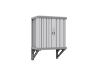

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1fdmkzonjawugicmdts13b7bw94o con tipo MIME image/jpeg


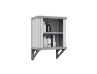

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1fdmkzonjawugixgtckoorpk3fdy con tipo MIME image/jpeg


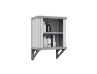

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1fdmkzonjawugip8ng8fi9hj4ede con tipo MIME image/jpeg


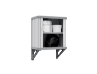

✅ Imagen descargada correctamente desde https://media.adeo.com/media/qsi8uetrzxi1fdmkzonjawugicopxpx1ee14xpe con tipo MIME image/jpeg
✅ IMAGEN SELECCIONADA: 1/4
📐 Tipo de dimensionamiento: 3D
🎯 ¿Puede añadir cotas 3D?: SÍ
🔍 Confianza: high
⭐ Puntuación de calidad: 10/10

📝 Razón:
   Image 1 provides a clear isometric view of the product, allowing for the simultaneous display and measurement of all three dimensions: width, height, and depth. The product is fully visible, sharply focused, and presented against a clean, white background with ample white space, which is ideal for placing technical dimension lines without any visual clutter or obstruction. The cabinet is closed, presenting the product in its most basic form, which is preferred for external dimensioning over images with internal contents.

📏 Dimensiones visibles:
   • Anchura: ✓
   • Altura: ✓
   • Profundidad: ✓


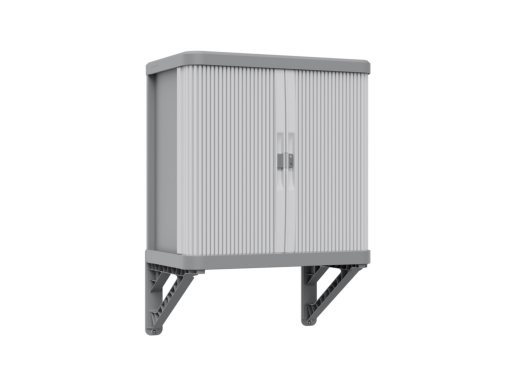

✅ Imagen selecionada para crear cotas desde https://media.adeo.com/media/qsi8uetrzxi1fdmkzonjawugicmdts13b7bw94o
Image saved at: imagenes_dameo_cotas/mod_Armario_utilitario/85206421.png

📤 Subiendo imagen a Google Drive...
✅ Carpeta 'Pruebas_cotas' encontrada: 1ExFcpw8ztACfMtFDhZRbwAAhD0s-faNc
   📂 En unidad compartida: 0AD4cVfPueYs1Uk9PVA
   🔍 Buscando subcarpeta 'mod_Armario_utilitario'...
   ✅ Subcarpeta encontrada: 17mY2JSOtwJ4oZ6k_kJpa72PmxyZz3o9-
   ✅ Imagen '85206421.png' subida correctamente
      📎 ID: 1UHYXJ2UYLHD3M-jZfzvivmiSq2MuzNE-
      🔗 Ver: https://drive.google.com/file/d/1UHYXJ2UYLHD3M-jZfzvivmiSq2MuzNE-/view?usp=drivesdk


In [78]:
selected_image = None

if images.empty:
    print(f"⚠️ No se encontraron imágenes para la referencia {reference}")
else:
    images_url = images['mediaLinkUrl'].tolist()
    image_parts = []
    images_bytes = []
    for idx, image_url in enumerate(images_url): 
        image_bytes, mime_type = download_image_from_url(image_url)
        
        if image_bytes:
            image = Image.open(BytesIO(image_bytes))
            images_bytes.append(image)
            # Display the image
            plt.figure(figsize=(1, 1))
            plt.imshow(image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            
            # Agregar la imagen con su índice
            image_parts.append(Part.from_text(text=f"\n--- IMAGE {idx + 1} ---"))
            image_parts.append(Part.from_bytes(data=image_bytes, mime_type=mime_type))
            
            print(f"✅ Imagen descargada correctamente desde {image_url} con tipo MIME {mime_type}")

        else:
            print(f"⚠️ No se pudo descargar la imagen desde {image_url}")

    # Seleccionar la mejor imagen usando la función definida
    result = get_better_image_to_add_pattern(image_parts, number_dimensions)
    selected_index = result['selected_index']
    selected_image = images_bytes[selected_index]
    
    plt.imshow(selected_image)
    plt.axis('off') # Hide the X and Y axes
    plt.show()
    print(f"✅ Imagen selecionada para crear cotas desde {images_url[selected_index]}")

    # Guardo la imagen en local
    # Define your path and filename
    folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
    file_path = folder_path / f"{reference}.png"
    # Create the directory (parents=True creates all missing folders in the path)
    folder_path.mkdir(parents=True, exist_ok=True)
    selected_image.save(file_path)
    print(f"Image saved at: {file_path}")

    # Save image in drive 
    
print(f"\n📤 Subiendo imagen a Google Drive...")
    
# Buscar carpeta padre
parent_folder_id = get_drive_folder_id(DRIVE_FOLDER_NAME)

if parent_folder_id:
    # Crear/encontrar subcarpeta por código de modelo
    subfolder_id = get_or_create_drive_subfolder(f"mod_{model_name.replace(' ', '_')}", parent_folder_id)
    
    # Subir imagen directamente desde memoria (sin guardar en disco)
    drive_file = upload_image_to_drive_from_memory(
        image=selected_image,
        file_name=f"{reference}.png",
        folder_id=subfolder_id
    )
    
else:
    print(f"❌ No se pudo encontrar la carpeta '{DRIVE_FOLDER_NAME}' en Google Drive")
    print(f"   💡 Asegúrate de que existe o créala manualmente")

## Generar pictograma

In [83]:
# Crear pictograma a partir de la imagen seleccionada
print(f"\n📐 Generando pictograma lineal a partir de la imagen seleccionada")
pictogram = get_pictogram_from_image(selected_image)
pictogram_image = Image.open(BytesIO(pictogram.candidates[0].content.parts[0].inline_data.data))
plt.figure(figsize=(5, 5))
plt.imshow(pictogram_image)
plt.axis('off') # Hide the X and Y axes
plt.show()
print("✅ Pictograma generado correctamente")

# Guardar pictograma localmente
folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
file_path = folder_path / f"{reference}-pictogram.jpg"
# Guardar la imagen
pictogram_image.save(file_path)

# Guardar drive 
drive_file = upload_image_to_drive_from_memory(
    image=pictogram_image,
    file_name=f"{reference}-pictogram.jpg",
    folder_id=subfolder_id
)


📐 Generando pictograma lineal a partir de la imagen seleccionada


KeyboardInterrupt: 

## Añadir cotas segun las dimensios obtenidas


📐 Dimensiones detectadas como visibles:
   • Anchura: ✓
   • Altura: ✓
   • Profundidad: ✓
TASK: Overlay exactly 3 total technical dimension annotations onto the attached image.

STYLE DEFINITION:
Every annotation must be a single 'Technical Bracket'. A Technical Bracket is one solid black line, exactly two arrowheads (one at each end), and one centered text label using a comma (,) for decimals.

ANNOTATIONS TO DRAW:
1. Width: Draw exactly one vertical Technical Bracket aligned with the outermost left vertical boundary of the object. The line must span from the highest pixel to the lowest pixel of the entire product, ensuring any legs or mounting brackets are included. labeled '59 cm'.
2. Height: Draw exactly one Technical Bracket parallel to the primary horizontal front-facing bottom edge. This line represents the maximum horizontal span of the product's front face. labeled '59.5 cm'.
3. Depth: Draw exactly one Technical Bracket parallel to the receding side edge of the product. This

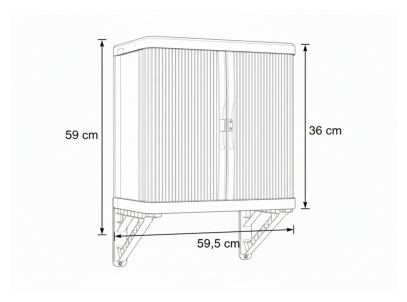

   ✅ Imagen '85206421-pat-1.jpg' subida correctamente
      📎 ID: 1zMerkJGy-vpjjShfG8drMY4W1ThZguUi
      🔗 Ver: https://drive.google.com/file/d/1zMerkJGy-vpjjShfG8drMY4W1ThZguUi/view?usp=drivesdk


In [86]:
# Obtener las dimensiones visibles del resultado de selección de imagen
visible_dims = result.get('visible_dimensions', {})

print(f"\n📐 Dimensiones detectadas como visibles:")
print(f"   • Anchura: {'✓' if visible_dims.get('width') else '✗'}")
print(f"   • Altura: {'✓' if visible_dims.get('height') else '✗'}")
print(f"   • Profundidad: {'✓' if visible_dims.get('depth') else '✗'}")

# Generar imagen con cotas usando solo las dimensiones visibles
response = get_dimensions_added_from_pictogram(
    dimensiones=dimensiones,
    image=pictogram_image,
    visible_dimensions=visible_dims
)

if response:
    print("✅ Imagen con cotas generada correctamente")
else:
    print("⚠️ No se pudo generar la imagen con cotas")
    
# Extraer la imagen de la respuesta
if response and response.candidates:
    # Obtener la primera parte de la respuesta que contiene la imagen
    for part in response.candidates[0].content.parts:
        if part.inline_data:
            # Convertir los bytes de la imagen a PIL Image
            image_data = part.inline_data.data
            generated_image = Image.open(BytesIO(image_data))
            
            # Mostrar la imagen
            plt.figure(figsize=(5, 5))
            plt.imshow(generated_image)
            plt.axis('off') # Hide the X and Y axes
            plt.show()
            folder_path = Path(FOLDER_IMAGES) / f"mod_{model_name.replace(' ', '_')}"
            file_path = folder_path / f"{reference}-pat-01.jpg"
            # Guardar la imagen
            generated_image.save(file_path)
            # Guardar drive 
            drive_file = upload_image_to_drive_from_memory(
                image=generated_image,
                file_name=f"{reference}-pat-1.jpg",
                folder_id=subfolder_id
            )